In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

/Users/myles/Desktop/Consumer Report/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Top Level Summary
This notebook provides a comprehensive analysis of consumer complaints submitted to the Consumer Financial Protection Bureau (CFPB) over the past five years, with a special emphasis on those tagged as 'servicemember.' The workflow begins with careful data cleaning and segmentation, isolating servicemember complaints from the general population to enable fair and meaningful comparisons. Exploratory visualizations reveal key trends in complaint volume, product and issue frequency, and highlight seasonal patterns such as the PCS (Permanent Change of Station) season. Comparative analyses normalize complaint rates to account for group size differences, uncovering which issues and companies are disproportionately represented among servicemember submissions. Advanced natural language processing techniques—including topic modeling, n-gram frequency analysis, and semantic clustering using sentence embeddings—are applied to the complaint narratives, providing deeper insight into the language and themes that distinguish servicemember complaints. Clusters are visualized using t-SNE, and representative complaint samples are provided to enhance interpretability. Overall, this project demonstrates a robust approach to data cleaning, statistical analysis, and modern NLP, yielding actionable insights for consumer protection stakeholders and showcasing portfolio-ready skills for data science roles.

### Exploratory Analysis Summary

This phase focuses on cleaning and structuring the CFPB complaint dataset to isolate servicemember-tagged records for comparative analysis. Key steps included filtering for valid dates and non-null narratives, separating servicemember complaints into a distinct subset, and removing them from the general dataset to maintain exclusivity. Initial visualizations examined complaint volume over time, issue frequency, and narrative characteristics, establishing a foundation for subsequent sentiment and topic modeling.


In [2]:
# Load data
df = pd.read_csv('/Users/myles/Desktop/Consumer Report/data/complaints-csv.csv')

In [3]:
# Exploratory analysis
print(df.shape)
print(df.columns)
print(df.info())
print(df.head(2))

(140222, 18)
Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140222 entries, 0 to 140221
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date received                 140222 non-null  object 
 1   Product                       140222 non-null  object 
 2   Sub-product                   140222 non-null  object 
 3   Issue                         140222 non-null  object 
 4   Sub-issue                     94364 non-null   object 
 5   Consumer complaint narrative  140222 non-null  object 
 6   Company 

In [4]:
# Data cleaning - Seperating out complaints tagged as servicemember complaints from the whole
df['Date received'] = pd.to_datetime(df['Date received'])
df = df[df['Date received'].notnull()]
df_clean = df[df['Consumer complaint narrative'].notnull()]

df_sm = df_clean[
    (df_clean['Tags'].str.contains("Servicemember", case=False, na=False))].copy()

df_clean = df_clean[
    ~df_clean['Tags'].str.contains("Servicemember", case=False, na=False)].copy()

/var/folders/zg/_j5hfs9d12d155g0l1sy26n00000gn/T/ipykernel_23213/2842439791.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date received'] = pd.to_datetime(df['Date received'])


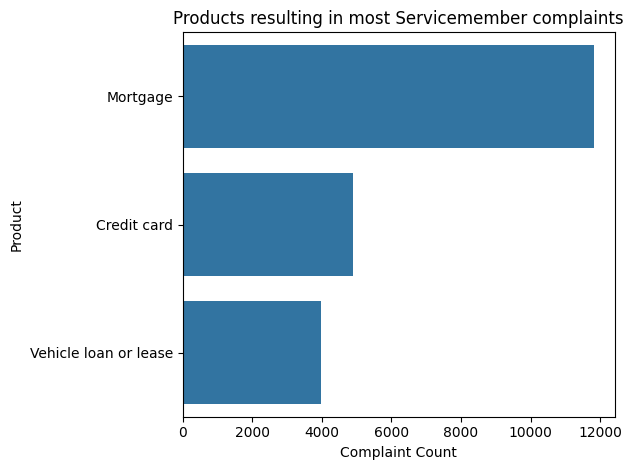

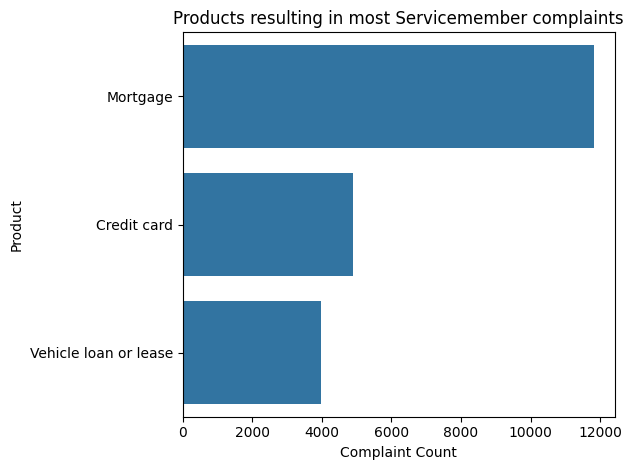

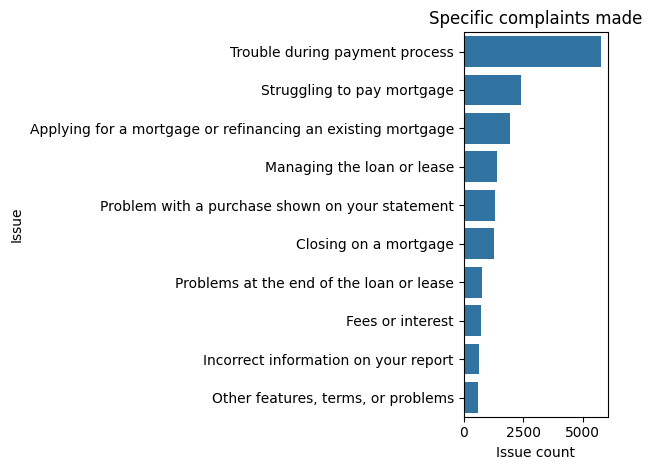

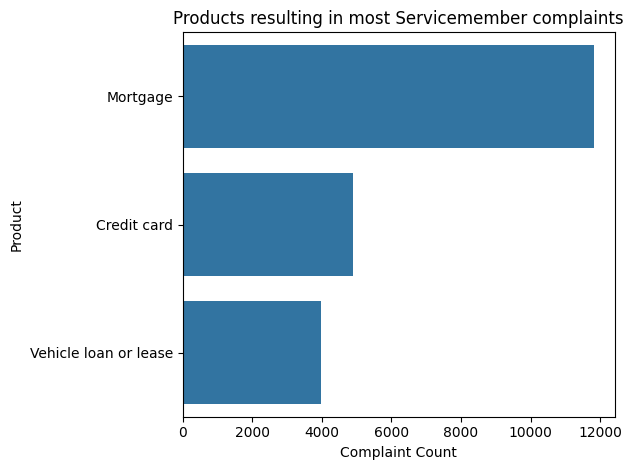

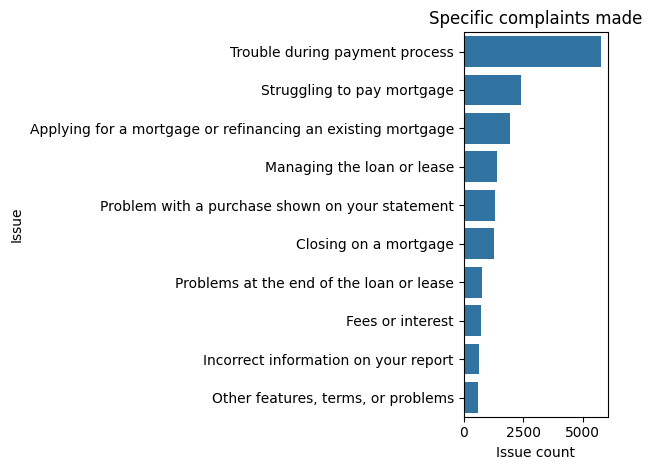

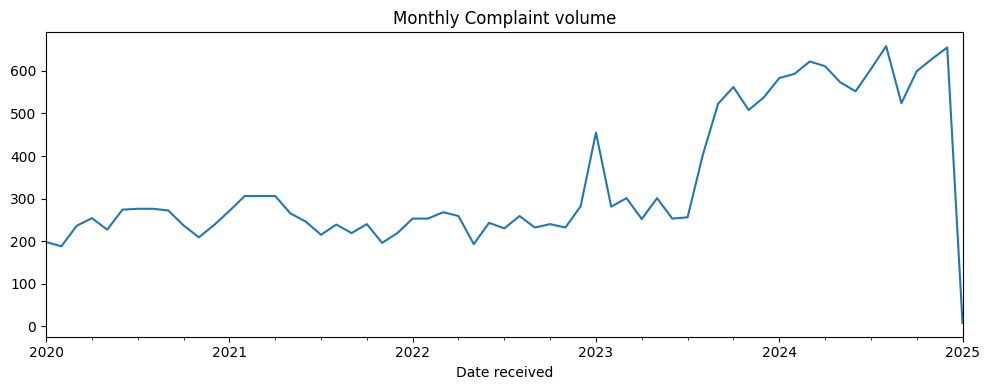

In [5]:
# Visualizing Servicemember complaints

# Top products
products_sm = df_sm['Product'].value_counts().head(5)
sns.barplot(x=products_sm.values, y=products_sm.index)
plt.title("Products resulting in most Servicemember complaints")
plt.xlabel("Complaint Count")
plt.tight_layout()
plt.show()

# Top issues
issues_sm = df_sm['Issue'].value_counts().head(10)
sns.barplot(x=issues_sm, y=issues_sm.index)
plt.title("Specific complaints made")
plt.xlabel("Issue count")
plt.tight_layout()
plt.show()

# Complaints over time
monthly_sm = df_sm.groupby(df_sm['Date received'].dt.to_period("M")).size()
monthly_sm.plot(kind='line', figsize=(10,4), title="Monthly Complaint volume")
plt.tight_layout()
plt.show()


<Axes: ylabel='Issue'>

<Axes: ylabel='Issue'>

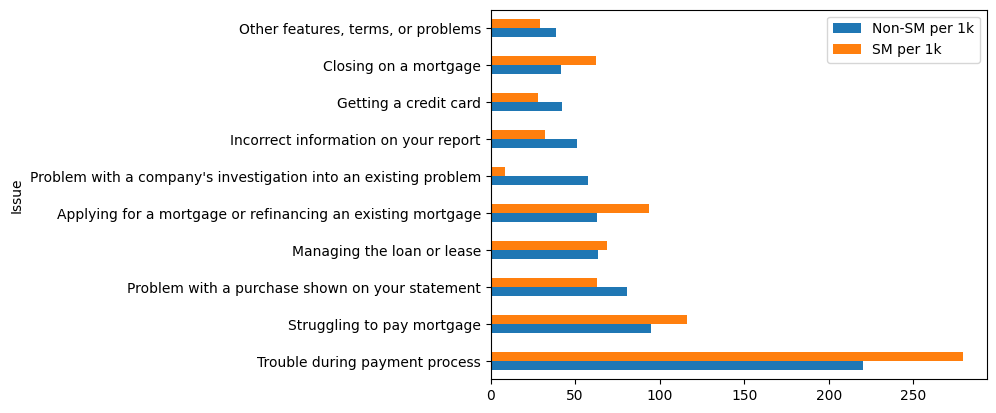

In [6]:
# Brief comparative analysis

#Issue analysis
# Total counts for normalization
total_clean = len(df_clean)
total_sm = len(df_sm)

# Top 10 issues in general population
top_issues_clean = df_clean['Issue'].value_counts().head(10)

# Match servicemember counts to same issues
top_issues_sm = df_sm['Issue'].value_counts().reindex(top_issues_clean.index).fillna(0)

# Normalize to complaints per 1,000
norm_clean = (top_issues_clean / total_clean * 1000).round(2)
norm_sm = (top_issues_sm / total_sm * 1000).round(2)

# Combine and plot
pd.concat([norm_clean, norm_sm], axis=1, keys=['Non-SM per 1k', 'SM per 1k']).plot.barh()

<Axes: title={'center': 'Monthly Complaint Rates per 1,000'}, xlabel='Date'>

<Axes: title={'center': 'Monthly Complaint Rates per 1,000'}, xlabel='Date'>

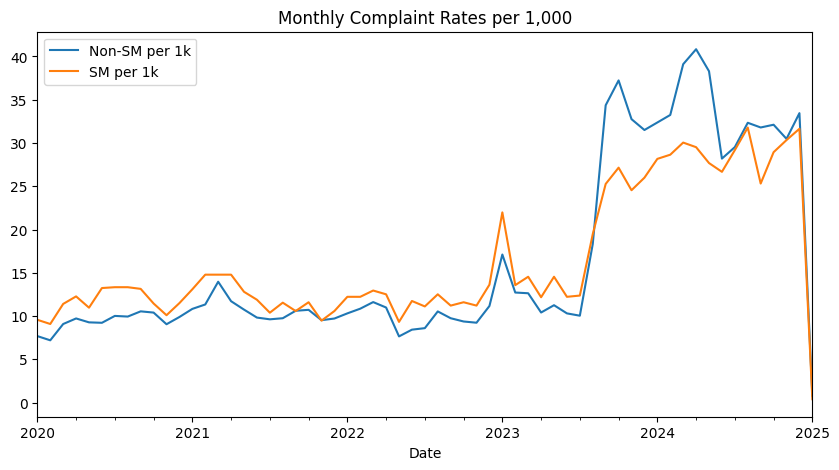

In [7]:
# Temporal Analyis
# Convert Dates
df_clean['Date'] = pd.to_datetime(df_clean['Date received'])
df_sm['Date'] = pd.to_datetime(df_sm['Date received'])

#Group by month
month_clean = df_clean.groupby(df_clean['Date'].dt.to_period('M')).size()
month_sm = df_sm.groupby(df_sm['Date'].dt.to_period('M')).size()

# Normalize to complaints per 1,000
rate_clean = (month_clean / len(df_clean) * 1000).rename('Non-SM per 1k')
rate_sm = (month_sm / len(df_sm) * 1000).rename('SM per 1k')

# Combine and plot
pd.concat([rate_clean, rate_sm], axis=1).plot(figsize=(10, 5), title='Monthly Complaint Rates per 1,000')

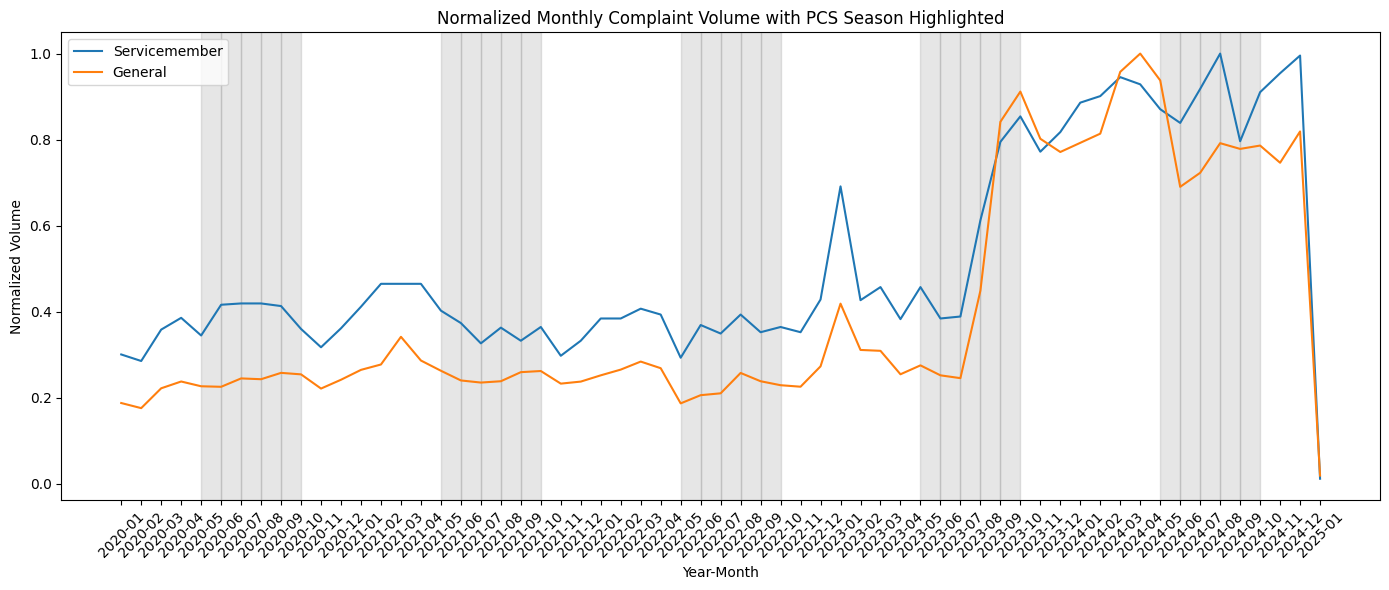

In [8]:
# Analysis on 'PCS season'

# Preprocessing function
def preprocess(df):
    df['Date received'] = pd.to_datetime(df['Date received'], errors='coerce')
    df['year_month'] = df['Date received'].dt.to_period('M')
    df['month'] = df['Date received'].dt.month
    df['is_pcs_season'] = df['month'].between(5, 9)  # May to September
    return df

# Process data
df_sm = preprocess(df_sm)
df_clean = preprocess(df_clean)

# Aggregate monthly counts
sm_counts = df_sm.groupby('year_month').size().reset_index(name='count')
sm_counts['source'] = 'Servicemember'
sm_counts['is_pcs_season'] = sm_counts['year_month'].dt.month.between(5, 9)

gen_counts = df_clean.groupby('year_month').size().reset_index(name='count')
gen_counts['source'] = 'General'
gen_counts['is_pcs_season'] = gen_counts['year_month'].dt.month.between(5, 9)

# Normalize within each group
sm_counts['normalized'] = sm_counts['count'] / sm_counts['count'].max()
gen_counts['normalized'] = gen_counts['count'] / gen_counts['count'].max()

# Combine and plot
combined = pd.concat([sm_counts, gen_counts])
combined.sort_values('year_month', inplace=True)

fig, ax = plt.subplots(figsize=(14, 6))

for group in ['Servicemember', 'General']:
    subset = combined[combined['source'] == group]
    ax.plot(subset['year_month'].astype(str), subset['normalized'], label=group)

# Shade PCS season months
for ym, is_pcs in zip(combined['year_month'], combined['is_pcs_season']):
    if is_pcs:
        ax.axvspan(str(ym), str(ym + 1), color='gray', alpha=0.1)

ax.set_title('Normalized Monthly Complaint Volume with PCS Season Highlighted')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Normalized Volume')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


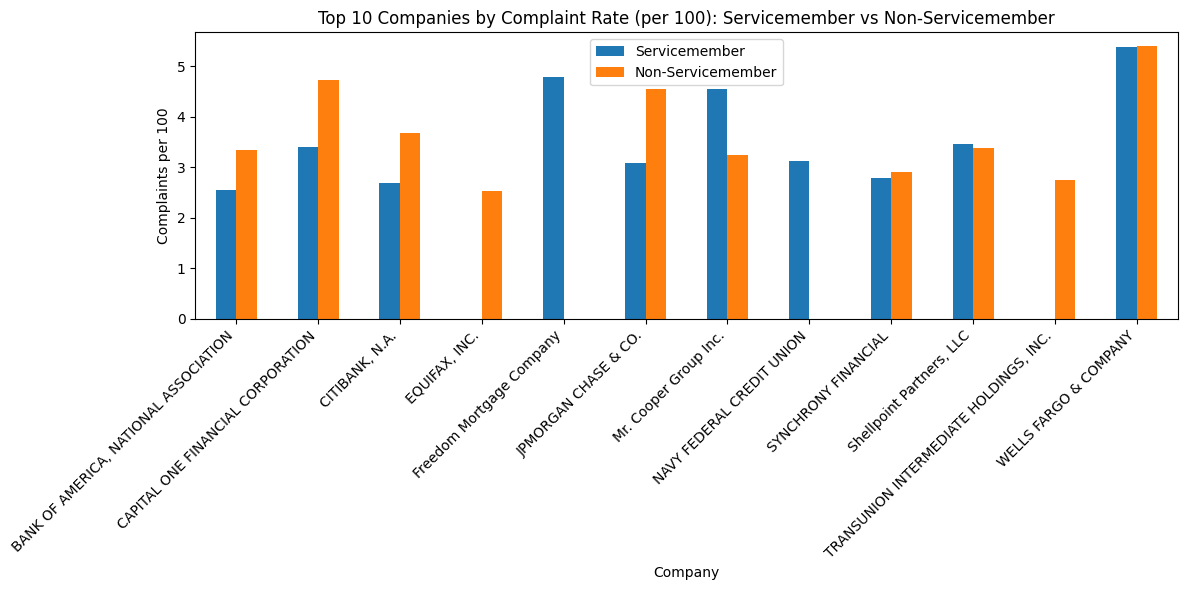

In [9]:
# Top 10 companies by complaint count, split by servicemember status, normalized per 100 complaints

products = ["Mortgage", "Credit card", "Vehicle loan or lease"]
filtered_sm = df_sm[df_sm['Product'].isin(products)]
filtered_clean = df_clean[df_clean['Product'].isin(products)]

# Aggregate complaint counts by company for each group
top_sm = filtered_sm['Company'].value_counts().head(10)
top_clean = filtered_clean['Company'].value_counts().head(10)

# Normalize counts per 100 complaints in each group
top_sm_norm = (top_sm / len(filtered_sm) * 100).round(2)
top_clean_norm = (top_clean / len(filtered_clean) * 100).round(2)

# Combine into a DataFrame for plotting
df_top = pd.DataFrame({
    'Servicemember': top_sm_norm,
    'Non-Servicemember': top_clean_norm
}).fillna(0)

# Plot side-by-side bars
df_top.plot.bar(
    figsize=(12,6),
    color=['#1f77b4', '#ff7f0e']
)
plt.title("Top 10 Companies by Complaint Rate (per 100): Servicemember vs Non-Servicemember")
plt.xlabel("Company")
plt.ylabel("Complaints per 100")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Narrative Trend Analysis

This phase of the analysis focuses on extracting structural and thematic patterns from consumer complaint narratives, comparing servicemember submissions against general complaints to identify any distinctive trends. Rather than measuring sentiment polarity—given the inherently negative nature of the data—the approach emphasizes lexical frequency analysis, topic modeling via LDA, and semantic clustering using sentence embeddings to uncover differences in language use, issue framing, and narrative density. Complaints are preprocessed for consistency, and PCS-season flags are used to assess whether relocation periods correspond with shifts in narrative content or emphasis.

In [10]:
# Preprocessing
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text))
    text = re.sub(r'[\w\s]', '', text)
    text = text.lower().strip()
    return text

def preprocess_narratives(df):
    df = df[df['Consumer complaint narrative'].notna().copy()]
    return df

df_sm_na = preprocess_narratives(df_sm)
df_clean_na = preprocess_narratives(df_clean)

In [11]:
# Token comparison
def get_top_ngrams(corpus, ngram_range=(1,2), top_n=20):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    return sorted(freqs, key=lambda x: x[1], reverse=True)[:top_n]

sm_ngrams = get_top_ngrams(df_sm_na['Consumer complaint narrative'])
gen_ngrams = get_top_ngrams(df_clean_na['Consumer complaint narrative'])  

In [12]:
# Topic modeling
def lda_topics(corpus, n_topics=6):
    tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=10)
    X = tfidf.fit_transform(corpus)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    terms = tfidf.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_terms = [terms[i] for i in topic.argsort()[:-11:-1]]
        topics.append(top_terms)
    return topics

sm_topics = lda_topics(df_sm_na['Consumer complaint narrative'])
gen_topics = lda_topics(df_clean_na['Consumer complaint narrative'])

In [13]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def cluster_narratives(texts, n_clusters=6):
    embeddings = model.encode(texts, show_progress_bar=True)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

df_sm_na['cluster'] = cluster_narratives(df_sm['Consumer complaint narrative'].tolist())
df_clean_na['cluster'] = cluster_narratives(df_clean['Consumer complaint narrative'].tolist())

Batches: 100%|██████████| 647/647 [01:00<00:00, 10.61it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Batches: 100%|██████████| 3736/3736 [05:06<00:00, 12.21it/s]


Batches: 100%|██████████| 647/647 [00:56<00:00, 11.37it/s]


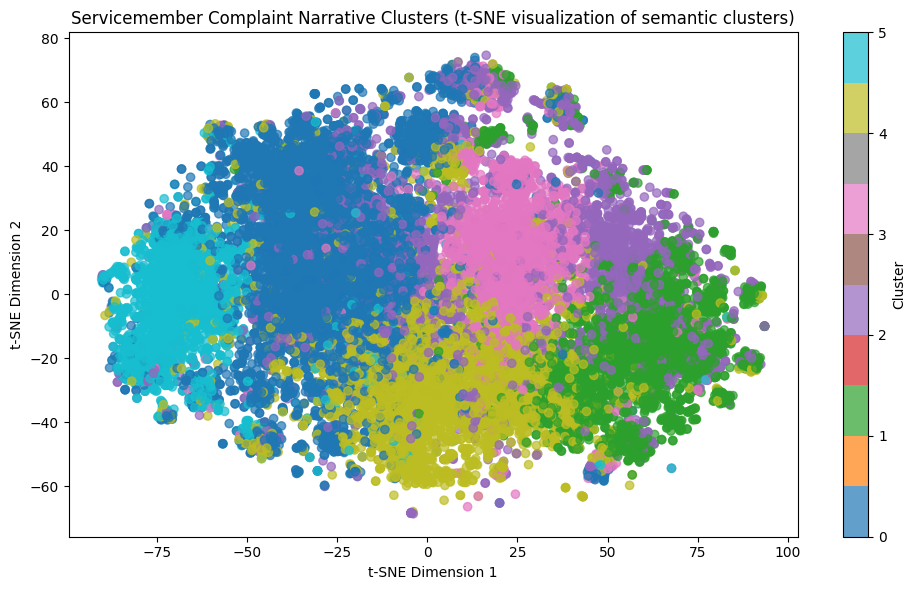


Cluster 0 sample complaints:
- I placed my mortgage into forbearance in XXXX oXXXX XXXX and missed 7 total payments. XXXX of XXXX was the beginning of XXXX and the forbearance guidelines were not fully established by any company. I...
- I was approved for tax exemption in XX/XX/2022, retroactively, the extra money that was paid for tax hasn't been returned to me. 

I caught XXXX in XX/XX/2022. I requested a forbearance due to other m...

Cluster 1 sample complaints:
- The problem is with fraudulent charges that were made on my Ally XXXX  acct. ending in XXXX, in XXXX, XXXX, for {$14.00}, {$21.00}, {$19.00}, and {$18.00}, totaling {$73.00}, and on XX/XX/XXXX for {$1...
- To Whom it May Concern, I closed my account from your credit card company ( I was a card holder for 21 years ), when I first was a member, the interest rate was a fixed rate of 14 % ( estimated ), in ...

Cluster 2 sample complaints:
- I filed a complaint with the CFPB in XXXX over this issue about the Goldman Sachs an

Batches: 100%|██████████| 3736/3736 [05:03<00:00, 12.31it/s]


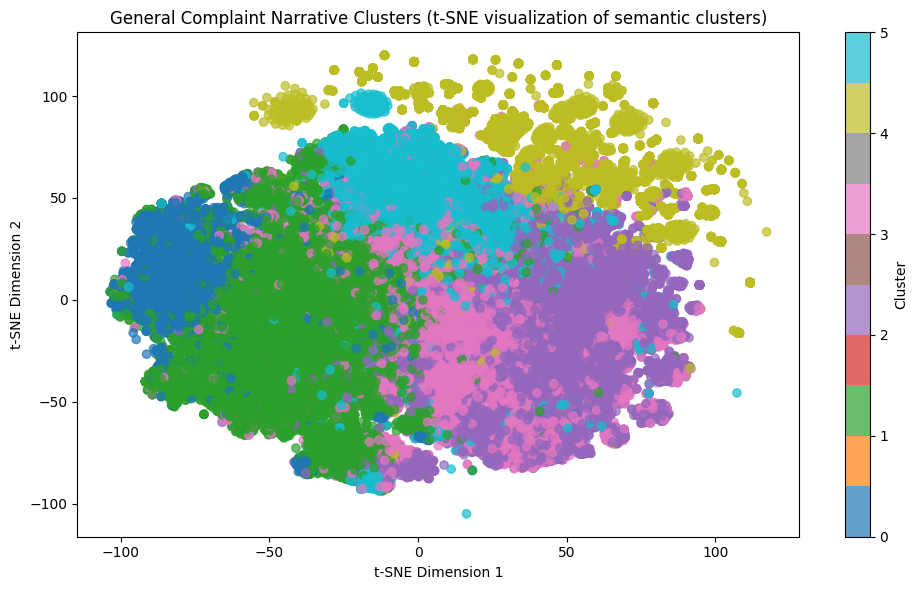


Cluster 0 sample complaints:
- Received noticed after XX/XX/XXXX escrow analysis that there was an escrow shortage and my payment would be increased by about XXXX dollars per month to cover this. When reviewing the escrow analysis ...
- I have a conventional loan that I have always been on time with and not had an escrow account. My home insurance provider is no longer covering home insurance and I missed the notice and had a very sm...

Cluster 1 sample complaints:
- I was approved for a USDA loan and purchased my current residence in XXXX. I am a single woman living alone, and in XXXX, I had to accept a significant decrease in income due to difficulties finding e...
- On XX/XX/2021 I attempted to get a mortgage from Bank of America. The first words out of the Sr. Loan Officers mouth were " be nice on the survey no matter what happens ''. That should have thrown up ...

Cluster 2 sample complaints:
- I am filing this complaint regarding XXXX from Discover 's executive office, phone n

In [15]:
# Interpretable cluster visualization using t-SNE and sample complaints
from sklearn.manifold import TSNE


def plot_tsne_clusters(texts, labels, title, n_samples=2):
    # Get embeddings
    embeddings = model.encode(texts, show_progress_bar=True)
    # Reduce to 2D with t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    reduced = tsne.fit_transform(embeddings)
    # Plot
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f'{title} (t-SNE visualization of semantic clusters)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()
    # Print sample complaints from each cluster for context
    labels = np.array(labels)
    for cluster_id in np.unique(labels):
        print(f'\nCluster {cluster_id} sample complaints:')
        idxs = np.where(labels == cluster_id)[0][:n_samples]
        for i in idxs:
            print(f'- {texts[i][:200]}...')

# Visualize servicemember clusters with t-SNE and sample complaints
plot_tsne_clusters(df_sm['Consumer complaint narrative'].tolist(), df_sm_na['cluster'], 'Servicemember Complaint Narrative Clusters')

# Visualize non-servicemember clusters with t-SNE and sample complaints
plot_tsne_clusters(df_clean['Consumer complaint narrative'].tolist(), df_clean_na['cluster'], 'General Complaint Narrative Clusters')